## **Laboratorio 13:** Despliegue de modelos con TensorFlow Lite
**Programa:** [Bootcamp en Visión Artificial para los ODS](https://github.com/EdwinTSalcedo/Bootcamp-Computer-Vision-for-the-SDGs) - **Autor:** [Christian Conchari](https://github.com/ChristianConchari)

Registra los datos de tu equipo en esta sección al finalizar el laboratorio. 

**Nombre de equipo:**

**Miembros de equipo:**
- << nombre >> << apellido >> (Contribución sobre el 25%)
- << nombre >> << apellido >> (Contribución sobre el 25%)
- << nombre >> << apellido >> (Contribución sobre el 25%)
- << nombre >> << apellido >> (Contribución sobre el 25%)


## 1. Configuración del entorno
Comenzamos instalando las bibliotecas necesarias para poder aprovechar la GPU que nos ofrece el ambiente de Google Colab.

In [ ]:
!pip install tensorflow-gpu==2.0.0
!pip install tensorflow_hub
!pip install h5py==2.10.0 --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
ERROR: pip's dependency resolver does not 

Importamos bibliotecas con las que ya hemos trabajado anteriormente para las etapas de preprocesamiento y entrenamiento.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

In [ ]:
import pandas as pd

# Definimos la precisión de los datos que se presentarán mediante Pandas
pd.set_option("display.precision", 8)

Comprobamos la versión de Tensorflow, Hub, y el uso de GPU.

In [ ]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0
Hub version:  0.12.0
Eager mode:  True
GPU is available


## 2. Descargamos y preparamos las bases de datos con las que trabajaremos

In [ ]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

Definimos generadores de datos para los conjuntos de entrenamiento y de validación.

In [ ]:
IMAGE_SHAPE = (224, 224)

TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


In [ ]:
# Mostramos información del batch de datos definido
image_batch_train, label_batch_train = next(iter(train_generator))
print("Tamaño del batch de imágenes: ", image_batch_train.shape)
print("Tamaño del batch de etiquetas: ", label_batch_train.shape)

Tamaño del batch de imágenes:  (32, 224, 224, 3)
Tamaño del batch de etiquetas:  (32, 5)


In [ ]:
# Extraemos información de las etiquetas del conjunto de datos
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Daisy' 'Dandelion' 'Roses' 'Sunflowers' 'Tulips']


##3. Definimos una arquitectura de CNN simple

In [ ]:
# Importamos la biblioteca de regularizadores para ayudar al modelo a generalizar
from tensorflow.keras import regularizers

model = tf.keras.models.Sequential([
              tf.keras.layers.Conv2D(256, (3,3), activation = "relu"),
              tf.keras.layers.MaxPool2D((2,2)),
              tf.keras.layers.Conv2D(128, (3,3), activation = "relu"),
              tf.keras.layers.MaxPool2D((2,2)),
              tf.keras.layers.Conv2D(64, (3,3), activation = "relu"),
              tf.keras.layers.MaxPool2D((2,2)),
              tf.keras.layers.Conv2D(32, (3,3), activation = "relu"),
              tf.keras.layers.MaxPool2D((2,2)),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(64, kernel_regularizer = regularizers.l2(1e-5), activation = "relu"),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(32, kernel_regularizer= regularizers.l2(1e-5),activation = "relu"),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(len(dataset_labels), activation = "softmax")
])

model.build((None, 224, 224, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  1

Compilamos la arquitectura recién definida.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])

Entrenamos nuestro modelo con 10 epochs.

In [ ]:
hist = model.fit(
    train_generator, 
    epochs=10,
    verbose=1,
    validation_data=valid_generator).history

Train for 92 steps, validate for 23 steps
Epoch 1/10
92/92 [==============================] - 41s 441ms/step - loss: 1.4785 - acc: 0.3396 - val_loss: 1.2725 - val_acc: 0.4665
Epoch 2/10
92/92 [==============================] - 33s 361ms/step - loss: 1.2136 - acc: 0.5073 - val_loss: 1.1064 - val_acc: 0.5677
Epoch 3/10
92/92 [==============================] - 33s 356ms/step - loss: 1.1043 - acc: 0.5631 - val_loss: 0.9901 - val_acc: 0.6060
Epoch 4/10
92/92 [==============================] - 33s 357ms/step - loss: 0.9912 - acc: 0.6148 - val_loss: 1.0594 - val_acc: 0.6129
Epoch 5/10
92/92 [==============================] - 33s 357ms/step - loss: 0.8978 - acc: 0.6730 - val_loss: 0.9642 - val_acc: 0.6265
Epoch 6/10
92/92 [==============================] - 33s 357ms/step - loss: 0.8277 - acc: 0.6982 - val_loss: 0.9878 - val_acc: 0.6389
Epoch 7/10
92/92 [==============================] - 33s 358ms/step - loss: 0.7620 - acc: 0.7309 - val_loss: 1.0057 - val_acc: 0.6430
Epoch 8/10
92/92 [=========

## 4. Exportamos y cargamos el modelo mediante Tensorflow y Keras

Utilizamos Tensorflow para exportar las información completa del modelo que acabamos de entrenar.

In [ ]:
!mkdir "tf_models"

model.save("tf_models/flowers_model.h5")
print("Modelos Tensorflow y sus tamaños:")
!ls "tf_models" -lh

mkdir: cannot create directory ‘tf_models’: File exists
Modelos Tensorflow y sus tamaños:
total 8.0M
-rw-r--r-- 1 root root 8.0M Jul  7 03:25 flowers_model.h5


Cargamos el modelo desde la ruta en la que lo guardamos mediante Tensorflow.

In [ ]:
flowers_model =  tf.keras.models.load_model("tf_models/flowers_model.h5")
flowers_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  1

## 5. Evaluamos el modelo de Tensorflow

Iteramos en el conjunto de datos de validación para extraer un batch de imagenes y un batch de etiquetas verdaderas.

In [ ]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

Realizamos predicciones para un batch de imagenes.

In [ ]:
import time

start_time = time.time()
tf_model_predictions = flowers_model(val_image_batch)
end_time = time.time()

Visualizamos las predicciones realizadas por el modelo de Tensorflow

In [ ]:
# Convertimos los resultados de la predicción en una tabla de datos de Pandas para una mejor visualización

tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Resultados de la predicción de los primeros 5 elementos del batch de datos")
print(f'Se proceso un batch de imagenes en {round((end_time-start_time)*1000,2)} ms')

print("")
tf_pred_dataframe.head()

Resultados de la predicción de los primeros 5 elementos del batch de datos
Se proceso un batch de imagenes en 194.71 ms



,Daisy,Dandelion,Roses,Sunflowers,Tulips
0,0.12686501,0.20941749,0.21663226,0.15720144,0.28988379
1,0.92605305,0.03057955,0.00866091,0.00917872,0.02552786
2,0.00141795,0.00242600,0.59574825,0.00080514,0.39960262
3,0.00000005,0.00024852,0.00000063,0.99966013,0.00009065
4,0.06495341,0.78544784,0.09972544,0.00914716,0.04072622


Convertimos las resultados de la predicción a valores entendibles para humanos.

In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

Visualizamos las predicciones para un batch de imagenes,

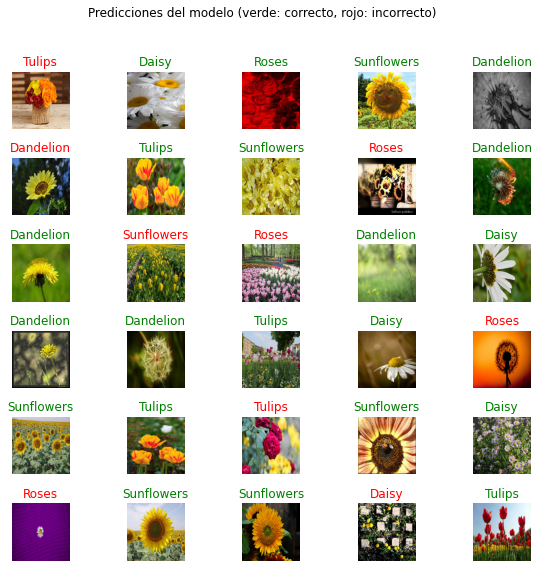

In [ ]:
# Mostramos el batch de imágenes y etiquetas predicciones

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Predicciones del modelo (verde: correcto, rojo: incorrecto)")

## 6. Convertimos los modelos a TFLite

Si bien hemos logrado exportar el modelo que entrenamos para que pueda utilizarse en otros dispositivos, muchas veces nos encontraremos con que el hardware objetivo en el que planeamos desplegar nuestro modelo tiene una capacidad de computo límitada, frente al dispositivo en el que fue entrenado. En ese sentido, herramientas como Tensorflow Lite aparecen para ayudarnos a llevar modelos desde nuestro ambiente de entrenamiento, a dispositivos con prestaciones menores, como podría ser un telefono móvil o una Raspberry Pi.

In [ ]:
!mkdir "tflite_models"

mkdir: cannot create directory ‘tflite_models’: File exists


In [ ]:
TFLITE_MODEL = "tflite_models/flowers.tflite"

In [ ]:
# Obtenemos la función del modelo Keras.
run_model = tf.function(lambda x : flowers_model(x))

# Guardamos la función.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convertimos el modelo al formato de TFLite
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

print("Modelos TFLite y sus tamaños:")
!ls "tflite_models" -lh

Modelos TFLite y sus tamaños:
total 2.7M
-rw-r--r-- 1 root root 2.7M Jul  7 03:43 flowers.tflite


En este punto notemos que el modelo de TFlite tiene un tamaño menor frente al modelo original de Tensorflow. Nuestro siguiente paso será comprobar los detalles de los tensores de entrada y salida del modelo de TFlite.

In [ ]:
# Cargar el modelo TFLite y ver algunos detalles sobre la entrada/salida

tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Datos de entrada ==")
print("Nombre:", input_details[0]['name'])
print("Tamaño:", input_details[0]['shape'])
print("Tipo de datos:", input_details[0]['dtype'])

print("\n== Datos de salida ==")
print("Nombre:", output_details[0]['name'])
print("Tamaño:", output_details[0]['shape'])
print("Tipo de datos:", output_details[0]['dtype'])

== Datos de entrada ==
Nombre: x
Tamaño: [  1 224 224   3]
Tipo de datos: <class 'numpy.float32'>

== Datos de salida ==
Nombre: Identity
Tamaño: [1 5]
Tipo de datos: <class 'numpy.float32'>


Notemos que el formato de entrada del modelo TFLite cargado es 1x224x224x3, lo que significa que podemos hacer predicciones para una sola imagen. Cambiaremos el tamaño de los tensores de entrada y salida para poder hacer predicciones para un lote de 32 imágenes.

In [ ]:
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Datos de entrada ==")
print("Nombre:", input_details[0]['name'])
print("Tamaño:", input_details[0]['shape'])
print("Tipo de datos:", input_details[0]['dtype'])

print("\n== Datos de salida ==")
print("Nombre:", output_details[0]['name'])
print("Tamaño:", output_details[0]['shape'])
print("Tipo de datos:", output_details[0]['dtype'])

== Datos de entrada ==
Nombre: x
Tamaño: [ 32 224 224   3]
Tipo de datos: <class 'numpy.float32'>

== Datos de salida ==
Nombre: Identity
Tamaño: [32  5]
Tipo de datos: <class 'numpy.float32'>


## 7. Evaluamos el modelo de TFlite

In [ ]:
tflite_interpreter.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter.invoke()

start_time = time.time()
tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
end_time = time.time()

print("Tamaño de los resultados de la predicción:", tflite_model_predictions.shape)

Tamaño de los resultados de la predicción: (32, 5)


In [ ]:
# Convertimos los resultados de la predicción en una tabla de datos de Pandas para una mejor visualización

tflite_pred_dataframe = pd.DataFrame(tflite_model_predictions)
tflite_pred_dataframe.columns = dataset_labels

print("Resultados de la predicción TFLite para los primeros elementos")
print(f'Se proceso un batch de imagenes en {round((end_time-start_time)*1000,2)} ms')
print("")
tflite_pred_dataframe.head()

Resultados de la predicción TFLite para los primeros elementos
Se proceso un batch de imagenes en 0.11 ms



,Daisy,Dandelion,Roses,Sunflowers,Tulips
0,0.12686504,0.20941752,0.21663226,0.15720141,0.28988373
1,0.92605293,0.03057956,0.00866091,0.00917871,0.02552784
2,0.00141795,0.00242600,0.59574831,0.00080515,0.39960259
3,0.00000005,0.00024852,0.00000063,0.99966013,0.00009065
4,0.06495340,0.78544790,0.09972540,0.00914716,0.04072622


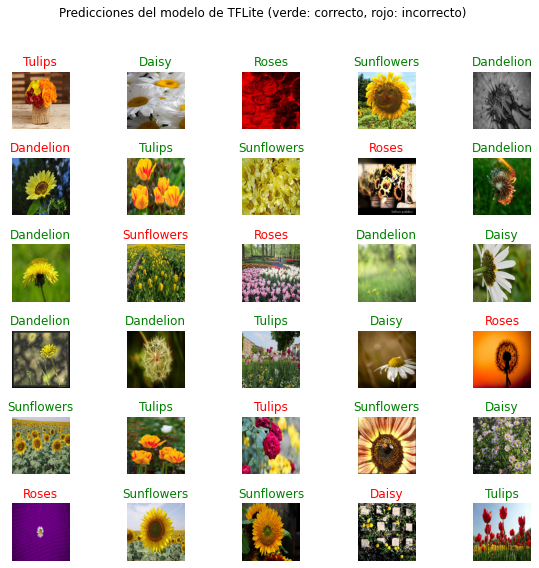

In [ ]:
# Mostramos el batch de imágenes y predicciones de etiquetas para el modelo TFLite

tflite_predicted_ids = np.argmax(tflite_model_predictions, axis=-1)
tflite_predicted_labels = dataset_labels[tflite_predicted_ids]
tflite_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if tflite_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(tflite_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Predicciones del modelo de TFLite (verde: correcto, rojo: incorrecto)")

Comparando los resultados obtenidos mediante el modelo original de Tensorflow y el modelo de Tensorflow Lite, notemos que el tiempo de inferencia se ha visto reducido de 194.71 ms (TF) frente a 0.11 ms (TFlite) sin sacrificar una reducción significativa en la precisión de predicción.

Si bien en este punto puede parecer no tan importante la diferencia de tiempo de inferencia, en aplicaciones donde el procesamiento de información en tiempo real es de suma importancia (conducción autonoma, monitoreo o vigilancia), una reducción del tiempo de inferencia se verá reflejada en una mayor cantidad de FPS lo cual hará mucho mas eficaz nuestro despliegue de visión por computador y aprendizaje profundo. 

##**Ejercicio 1:** Mejorando la precisión del modelo

Como habrás notado, la precisión del modelo que acabamos de entrenar no es la mejor. Por ese motivo, deberás definir una nueva arquitectura para mejorarlo, puedes aplicar aprendizaje por trasnferencia o definir una arquitectura por tu cuenta (si sigues este camino la mejora deberá ser sustancial y justificada). Para aplicar aprendizaje por transferencia puedes basarte en el trabajo que realizaste en el laboratorio 12 o seguir el tutorial [Transfer Learning con TensorFlow Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub). Una vez hayas definido la nueva arquitectura, sigue los pasos de este tutorial para convertir el modelo a Tensorflow Lite. La finalidad de este ejercicio es que obtengas el tamaño del modelo y el tiempo que le toma llevar a cabo la inferencia de un batch de imagenes con Tensorflow, y lo compares con el tamaño y tiempo de inferencia para el mismo batch de imagenes empleando Tensorflow Lite.

## **Ejercicio 2:** Cuantización post entrenamiento mediante TFlite

Recordando los conceptos de muestreo de señales, el proceso de cuantización se define como la **discretización de un rango continuo de amplitudes por aproximación o truncamiento de valores**. El resultado será un grupo más reducido de amplitudes discretas.

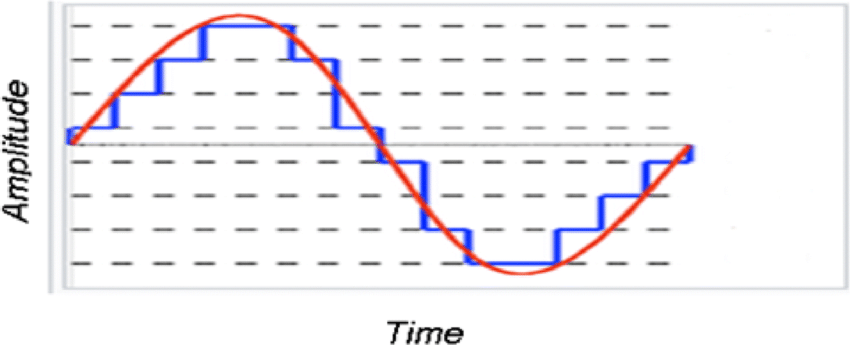

En el contexto del aprendizaje automatico, o más específico el aprendizaje profundo y las redes neuronales. Como sabes, una red neuronal se compone por parámetros y capas, donde cada capa transforma la imagen de entrada, separando y contrayendo sus características, resultando en la separación de las imágenes de entrada a sus distintas clases. Durante el proceso de entrenamiendo de una red neuronal, actualizaremos los parámetros del modelo, hasta que trabajando conjuntamente, estos puedan resolver el problema de clasificación de la mejor manera posible. Sin embargo, como habrás notado en el ejercicio anterior, para resolver problemas de clasificación más complejos, tendremos que optar por arquitecturas más extensas, lo que implica una mayor cantidad de parámetros, y consecuentemente un mayor tamaño y mayor cantidad de operaciones; lo cual limita que podamos desplegar nuestros modelos en dispositivos con capacidad de computo limitada, como son los telefonos móviles convencionales o los dispositivos embebidos.

En sentido a lo mencionado, múltiples técnicas han surgido en los últimos años, [podado de modelos](https://towardsdatascience.com/pruning-neural-networks-1bb3ab5791f9), [destilado de aprendizaje](https://analyticsindiamag.com/a-beginners-guide-to-knowledge-distillation-in-deep-learning/) o [cuantización](https://medium.com/@joel_34050/quantization-in-deep-learning-478417eab72b#:~:text=Quantization%20for%20deep%20learning%20is,cost%20of%20using%20neural%20networks.), siendo esta última técnica la que abordaremos en este ejercicio.

La intuición detrás de la cuantización es la siguiente: 

- La cuantización para el aprendizaje profundo es el proceso de aproximación de una red neuronal que utiliza números en precisión de punto flotante (Float16, Float32) por una red neuronal de números de bajo ancho de bits (Int8, Int16).

En ese sentido, estaríamos buscando reducir drásticamente tanto el requerimiento de memoria como el coste computacional del despliegue de un modelo de aprendizaje profundo. 

En este ejercicio deberás convertir el modelo que definiste y entrenaste en el ejercicio anterior y aplicar cuantización post entrenamiento, puedes revisar la siguiente información: [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization). Se espera que al igual a como hiciste en el ejercicio anterior, hagas una comparación de tamaño, tiempo de inferencia y precisión de clasificación, con los modelos de Tensorflow, Tensorflow Lite y el nuevo modelo de Tensorflow Lite cuantizado.

**Pista:** Al momento de convertir el modelo mediante TFLite también deberás trabajar con (**converter.optimizations**) y (**tf.lite.Optimize**). Puedes consultar mas información en la documentación: [TFlite Optimize](https://www.tensorflow.org/api_docs/python/tf/lite/Optimize)




